In [ ]:
bicycle = "http://josephsalmon.eu/enseignement/datasets/bicycle_db.csv"
path_bicycle = "./data/bicycle.txt"
pollution = "http://josephsalmon.eu/enseignement/datasets/Mesure_journaliere_Region_Occitanie_Polluants_Principaux.csv"

In [1]:
from download import download
import patsy
import numpy as np
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import t

sns.set_palette("colorblind")

%matplotlib notebook

In [ ]:
download(bicycle, path_bicycle, replace=False)

# Bike data

In [ ]:
df_bicycle = pd.read_csv(path_bicycle, sep=",", skiprows=2, converters={"heure": str})
pd.options.display.max_columns = 39
df_bicycle.head()

In [ ]:
df_bicycle = df_bicycle[["date", "mois", "jour", "heure", "departement", "en agglomeration",
                       "conditions atmosperiques", "categorie usager", "gravite accident",
                       "sexe", "age", "existence securite"]]
df_bicycle["heure"].replace("", np.nan, inplace=True)
df_bicycle["age"].replace(["2004-2005", "2016-2017", "2006-2007", "2012-2013", "2013-2014",
                           '2005-2006', "2006-2007"], np.nan, inplace=True)
df_bicycle["existence securite"].replace("Inconnu", np.nan, inplace=True)
df_bicycle.dropna(inplace=True)
df_bicycle.rename(columns = {"conditions atmosperiques": "conditions atmospheriques", "gravite accident": "gravite_accident"}, inplace=True)

for i, name in enumerate(df_bicycle.columns):
    print("\n############################")
    print("Column", name)
    print(df_bicycle[df_bicycle.columns[i]].unique(), "\n")

In [ ]:
df_bicycle.head()

In [ ]:
df_bicycle.set_index(pd.to_datetime(df_bicycle["heure"] + "/00 "+
                            df_bicycle["date"],
                            format="%H/%M %Y-%m-%d"), inplace=True)
df_bicycle.drop(columns=["date"], inplace=True)
df_bicycle = df_bicycle[df_bicycle.index.year!=2018]
df_bicycle.head()

In [ ]:
plt.figure()
df_bicycle.sexe.value_counts().plot(kind='pie')
plt.show()

In [ ]:
pd.crosstab(df_bicycle['existence securite'], df_bicycle['gravite_accident'], normalize='index', margins=True)*100

In [ ]:
df_bicycle["heure"] = pd.to_numeric(df_bicycle["heure"])

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.violinplot(x="gravite_accident", y="heure", hue = "sexe",
                    split=True, data=df_bicycle)
ax.set_xlabel('Gravite Accident')
ax.set_ylabel('Heure')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='small')
plt.ylim([0,24])
plt.tight_layout()
plt.show()

In [ ]:
lm_time_gravity = ols('heure ~ C(gravite_accident)', data=df_bicycle).fit()

In [ ]:
anova_time_grav = sm.stats.anova_lm(lm_time_gravity, typ=2)
anova_time_grav

In [ ]:
resid = lm_time_gravity.resid
import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(resid, plot=ax, fit=True)

## Visualize some things

In [ ]:
df_bicycle.groupby([df_bicycle.index.weekday, df_bicycle.index.hour])['sexe'].count().unstack(level=0).plot()

In [ ]:
data_days = df_bicycle.to_period("M")
data_days = data_days.pivot_table(index=data_days.index, columns='jour', aggfunc='size')

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data_days = pd.DataFrame({"days": days*int(data_days.shape[0]),
                         "number_accident": data_days.stack().values})


fig, ax = plt.subplots(figsize=(8,5))
ax = sns.violinplot(x="days", y="number_accident", data=data_days)
ax.set_ylabel("Nombre d'accidents")
ax.set_xlabel('Jour de la semaine')
plt.title("Nombre d'accidents suivant les jours de la semaine")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='small')
plt.tight_layout()
plt.show()

In [ ]:
lm_days = ols('number_accident ~ C(days)', data=data_days).fit()
anova_days = sm.stats.anova_lm(lm_days, typ=2)
print(anova_days)

resid_days = lm_days.resid
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(resid_days, plot=ax, fit=True)

## 2nd anova

In [ ]:
heures = df_bicycle.heure.isin(["6", "7", '8', '9', '10', "11", '12', '13', "14", "15", "16", "17", "18", "19", "20"])
df_all = df_bicycle[heures]
df_all = df_all.copy()
df_all["daytime"] = df_all.heure.isin(["6", "7", '8', '9', '10', "11", '12', "13"])
df_all['daytime'].replace(True, "matin", inplace=True)
df_all['daytime'].replace(False, "apres_midi", inplace=True)
df_all.head()

In [ ]:
data = df_all.to_period("M")
data = data.pivot_table(index=data.index, columns='daytime', aggfunc='size')
data.plot()

In [ ]:
data = pd.DataFrame({"accident_number": data.stack().values,
                     "daytime": ['6-13h', '14-20h']*int(data.shape[0])})
data

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.violinplot(x="daytime", y="accident_number", data=data)
ax.set_xlabel("Nombre d'accidents")
ax.set_ylabel('Période de la journée')
plt.title("Nombre d'accidents par mois de janvier 2005 à décembre 2017")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='small')
plt.tight_layout()
plt.show()

In [ ]:
lm_acc_day = ols('accident_number ~ C(daytime)', data=data).fit()
anova_acc_day = sm.stats.anova_lm(lm_acc_day, typ=2)
anova_acc_day

In [ ]:
resid_acc = lm_acc_day.resid
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(resid_acc, plot=ax, fit=True)

## Permutation test
Protocol:
* 2 groups A=control and B=test, we test the effect of the treatment
* H0 : mu_A >= mu_B (reject H0 means better treatment)
* set seed
* Assign values for the effect of the treatment (or placebo)
* Test stat = mu_test - mu_contral
* shuffle and recalculate the Test_stat J times big (in theory C_na^nA+nb
* plot the hist of the values
* p-val= number of stats over the first / J

In [2]:
class Treatment_test_simulation():

    def __init__(self, nb_patients, mean_A=None, mean_B=None, nb_permut=None, setseed=True):
        if (nb_patients % 2) != 0:
            nb_patients += 1  # only even number is easier
        self.n = nb_patients
        if mean_A is None:  # A=control ie gaussian mean effect is 5
            mean_A = 4  # 5
            # B : miracle drug without memory in the system and
        if mean_B is None:
            mean_B = 7  # B = test ie exponential mean effect is 7
        self.mean_A = mean_A
        self.mean_B = mean_B

        if nb_permut is None:  # alright for large numbers
            nb_permut = 100 * nb_patients
        self.nb_permut = nb_permut
        self.setseed = setseed
        if setseed:
            np.random.seed(11235813)

        self.group_A = np.random.normal(size=int(self.n/2),
                                        loc=self.mean_A)
        self.group_B = np.random.exponential(size=int(self.n/2),
                                             scale=self.mean_B)  # 1/lambda in python

    @staticmethod
    def compute_stat(rowtab):
        res = np.mean(rowtab[1, :]) - np.mean(rowtab[0, :])
        return res

    def permutation_test(self):
        J = self.nb_permut
        if self.setseed:
            rng = np.random.default_rng(seed=11235813)
        storage = np.zeros(J)
        row_tab = np.vstack((self.group_A, self.group_B))
        for j in range(J):
            data = row_tab.copy()
            rng.shuffle(data.reshape(-1), axis=0)
            storage[j] = self.compute_stat(data)
        return storage

    def plot_hist(self, storage):
        plt.figure()
        sns.distplot(storage)
        plt.show()

    def answer_test(self, storage):
        row_tab = np.vstack((self.group_A, self.group_B))
        ref_ = self.compute_stat(row_tab)
        nb_over_ref = np.sum(storage >= ref_)
        return nb_over_ref / self.nb_permut, ref_

    def perform_test(self, plot=True):
        stor = self.permutation_test()
        if plot:
            self.plot_hist(stor)
        pval, ref_ = self.answer_test(stor)
        return pval, ref_

In [3]:
test = Treatment_test_simulation(50, setseed=True, nb_permut=1000)

<IPython.core.display.Javascript object>


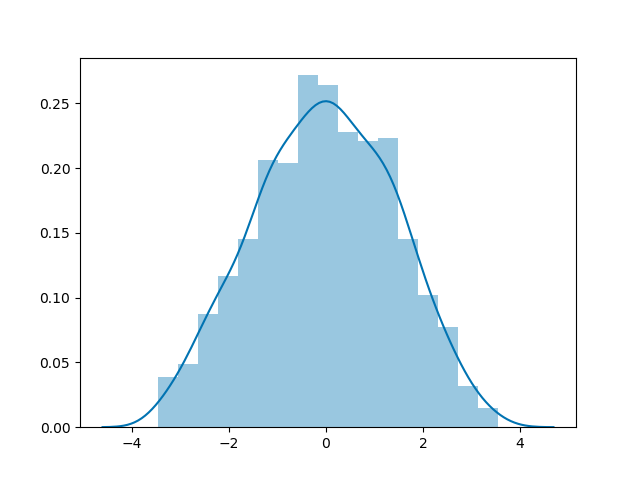

(0.034, 2.516236836730584)

In [4]:
test.perform_test()

<IPython.core.display.Javascript object>


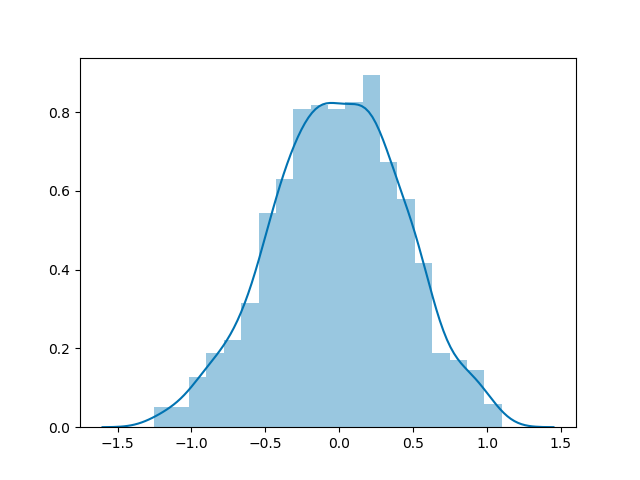

(0.595, -0.11757767797891439)

In [6]:
testNot = Treatment_test_simulation(50, mean_A = 2, mean_B = 2, setseed=True, nb_permut=1000)
testNot.perform_test()